In [1]:
import os
import random

import numpy as np
import pandas as pd
def load_imdb_sentiment_analysis_dataset(seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = "C:/Users/GCNDP/SentimentTrain"

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname),encoding="utf-8") as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname),encoding="utf-8") as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [2]:
data = load_imdb_sentiment_analysis_dataset()
#print(data)

In [3]:
(train_texts, train_labels), (val_texts, val_labels) = data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_num_classes(labels):
    """Gets the total number of classes.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)

    # Returns
        int, total number of classes.

    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


In [5]:
num_classes = get_num_classes(train_labels)
print(num_classes)

2


In [6]:
num_classes = get_num_classes(val_labels)
print(num_classes)

2


In [7]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """

    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

C:\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

TOP_K = 20000
# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index


In [9]:
# Vectorize texts.
x_train, x_val ,word_index = sequence_vectorize(train_texts, val_texts)

In [10]:
print(x_train.shape)

(25000, 500)


In [11]:
# Number of features will be the embedding input dimension. Add 1 for the
# reserved index 0.
num_features = min(len(word_index) + 1, TOP_K)
print(num_features)

20000


In [38]:
learning_rate=1e-3
epochs=10
batch_size=32
layers=2
units=64
dropout_rate=0.2
# Create model instance.
    # Create model instance.
learning_rate=1e-3
epochs=10
batch_size=128
blocks=2
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3
model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)


In [39]:
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 200)          4000000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d_20 (Separab (None, 500, 64)           13464     
_________________________________________________________________
separable_conv1d_21 (Separab (None, 500, 64)           4352      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 166, 64)           0         
_________________________________________________________________
separable_conv1d_22 (Separab (None, 166, 128)          8512      
_________________________________________________________________
separable_conv1d_23 (Separab (None, 166, 128)          16896     
__________

In [41]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [42]:
# Train and validate model.
#with tf.device('/device:GPU:0'):
    #history =
model.fit(
                x_train,
                train_labels,
                epochs=epochs,
               # callbacks=callbacks,
               # validation_data=(x_val, val_labels),
                verbose=2,  # Logs once per epoch.
                batch_size=batch_size)

C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor of shape [3,200,1] and type float
	 [[Node: training_4/Adam/zeros_1 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [3,200,1] values: [[0][0][0]]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training_4/Adam/zeros_1', defined at:
  File "C:\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Continuum\anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Continuum\anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Continuum\anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-ec530ef6c2d8>", line 11, in <module>
    batch_size=batch_size)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1348, in fit
    validation_steps=validation_steps)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_arrays.py", line 91, in fit_loop
    model._make_train_function()
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 588, in _make_train_function
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\optimizers.py", line 502, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\optimizers.py", line 502, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 968, in zeros
    v = array_ops.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1538, in zeros
    output = _constant_if_small(zero, shape, dtype, name)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1496, in _constant_if_small
    return constant(value, shape=shape, dtype=dtype, name=name)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\constant_op.py", line 202, in constant
    name=name).outputs[0]
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [3,200,1] and type float
	 [[Node: training_4/Adam/zeros_1 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [3,200,1] values: [[0][0][0]]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


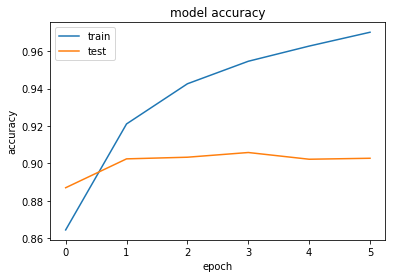

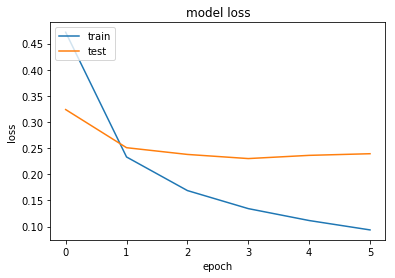

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Validation accuracy: 0.9027199999809266, loss: 0.23927112186431884


In [60]:
model.save('C:/Users/GCNDP/SentimentAnalysis/imdb_mlp_model.h5')

In [11]:
import keras
from keras import models
model = models.load_model('C:/Users/GCNDP/SentimentAnalysis/imdb_mlp_model.h5')

Using TensorFlow backend.


In [13]:
_, acc = model.evaluate(x_train, train_labels, verbose=0)
print( ' Train Accuracy: %f ' % (acc*100))
_, acc = model.evaluate(x_val, val_labels, verbose=0)
print( ' Test Accuracy: %f ' % (acc*100))

 Train Accuracy: 98.596000 
 Test Accuracy: 90.272000 


In [15]:
review = []
review.append("the movie had a good plot to it, and the actors did a magnificent job. Overall, i would recomend it.");
review.append("The characters voices were very good. I was only really bothered by Kanga. The music, however, was twice as loud in parts than the dialog, and incongruous to the film. As for the story, it was a bit preachy and militant in tone. Overall, I was disappointed, but I would go again just to see the same excitement on my child's face. I liked Lumpy's laugh...")
x_train, x_new = ngram_vectorize(train_texts,train_labels,review)

In [16]:
print(model.predict(x_new))

[[0.8480214 ]
 [0.35247958]]
